In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
#!unzip '/content/drive/MyDrive/Assignment 6/final_train.zip'

Streaming output truncated to the last 5000 lines.
  inflating: final_train/40/n02814860_150.JPEG  
  inflating: final_train/40/n02814860_152.JPEG  
  inflating: final_train/40/n02814860_155.JPEG  
  inflating: final_train/40/n02814860_156.JPEG  
  inflating: final_train/40/n02814860_159.JPEG  
  inflating: final_train/40/n02814860_160.JPEG  
  inflating: final_train/40/n02814860_162.JPEG  
  inflating: final_train/40/n02814860_164.JPEG  
  inflating: final_train/40/n02814860_165.JPEG  
  inflating: final_train/40/n02814860_166.JPEG  
  inflating: final_train/40/n02814860_167.JPEG  
  inflating: final_train/40/n02814860_170.JPEG  
  inflating: final_train/40/n02814860_172.JPEG  
  inflating: final_train/40/n02814860_18.JPEG  
  inflating: final_train/40/n02814860_180.JPEG  
  inflating: final_train/40/n02814860_181.JPEG  
  inflating: final_train/40/n02814860_183.JPEG  
  inflating: final_train/40/n02814860_186.JPEG  
  inflating: final_train/40/n02814860_19.JPEG  
  inflating: final_t

In [ ]:
#!unzip '/content/drive/MyDrive/Assignment 6/new_final_test.zip'

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
# Freeze training for all layers
model = models.vgg19_bn(pretrained=True)
for param in model.features.parameters():
    param.require_grad = False

# Newly created modules have require_grad=True by default
num_features = model.classifier[6].in_features
features = list(model.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, 59)]) # Add our layer with 4 outputs
model.classifier = nn.Sequential(*features) # Replace the model classifier
print(model)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 25

In [8]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
train_transforms = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomRotation(50,expand=True),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.1),
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ])

data = datasets.ImageFolder('/content/drive/MyDrive/Assignment 6/final_train', transform=train_transforms)
print(len(data[0]))
train_set,val_set=torch.utils.data.random_split(data, [9440,2360])
# #data loaders

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=True)


print("Classes: ")
class_names = data.classes
print(len(class_names))

2
Classes: 
59


In [ ]:
Epochs = 20
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

model.train()
batch_size = 32
for epoch in range(Epochs):  # loop over the dataset multiple times
    ep_accuracy = 0
    running_loss = 0.0
    pbar = tqdm(enumerate(train_loader))
    for i, data_im in pbar:
        # get the inputs
        inputs, labels = data_im
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = model(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        predictions = outputs.argmax(dim=1, keepdim=True).squeeze()
        correct = (predictions == labels).sum().item()
        ep_accuracy += correct
        accuracy = correct / batch_size
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {:.3f}'.format(
                epoch, i * len(inputs), len(train_loader.dataset),
                100. * i / len(train_loader),
                loss.item(), 100*accuracy))
    print("Training Accuracy:", 100. * ep_accuracy / len(train_loader.dataset))

    test_loss = 0
    correct = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(valid_loader):

            data, target = data.to(device), target.to(device)


            net_out = model(data)
            # sum up batch loss
            test_loss += criterion(net_out, target)
            predictions = net_out.argmax(dim=1, keepdim=True).squeeze()
            correct += (predictions == target).sum().item()


    print("Validation Accuracy:" , 100. * correct / len(valid_loader.dataset))
    print("Validation Loss:", test_loss / len(valid_loader.dataset)) 
    print("----------------------------------------------------------")   
    torch.save(model.state_dict(), '/content/drive/MyDrive/Assignment 6/vgg19.pth')
        


print('Finished Training')



0it [00:00, ?it/s]

Train Epoch: 0 [0/9440 (0%)]	Loss: 4.126388	Accuracy: 0.000: : 0it [00:01, ?it/s]

Train Epoch: 0 [0/9440 (0%)]	Loss: 4.126388	Accuracy: 0.000: : 1it [00:01,  1.48s/it]

Train Epoch: 0 [32/9440 (0%)]	Loss: 4.019679	Accuracy: 12.500: : 1it [00:02,  1.48s/it]

Train Epoch: 0 [32/9440 (0%)]	Loss: 4.019679	Accuracy: 12.500: : 2it [00:02,  1.46s/it]

Train Epoch: 0 [64/9440 (1%)]	Loss: 4.298740	Accuracy: 0.000: : 2it [00:04,  1.46s/it] 

Train Epoch: 0 [64/9440 (1%)]	Loss: 4.298740	Accuracy: 0.000: : 3it [00:04,  1.43s/it]

Train Epoch: 0 [96/9440 (1%)]	Loss: 4.091294	Accuracy: 3.125: : 3it [00:05,  1.43s/it]

Train Epoch: 0 [96/9440 (1%)]	Loss: 4.091294	Accuracy: 3.125: : 4it [00:05,  1.42s/it]

Train Epoch: 0 [128/9440 (1%)]	Loss: 4.095994	Accuracy: 3.125: : 4it [00:07,  1.42s/it]

Train Epoch: 0 [128/9440 (1%)]	Loss: 4.095994	Accuracy: 3.125: : 5it [00:07,  1.42s/it]

Train Epoch: 0 [160/9440 (2%)]	Loss: 4.110348	Accuracy: 0.000: : 5it [00:08,  1.42s/it]

Train Epoc

Training Accuracy: 40.190677966101696
Validation Accuracy: 66.01694915254237
Validation Loss: tensor(0.0392, device='cuda:0')
----------------------------------------------------------




0it [00:00, ?it/s]

Train Epoch: 1 [0/9440 (0%)]	Loss: 1.350627	Accuracy: 56.250: : 0it [00:01, ?it/s]

Train Epoch: 1 [0/9440 (0%)]	Loss: 1.350627	Accuracy: 56.250: : 1it [00:01,  1.51s/it]

Train Epoch: 1 [32/9440 (0%)]	Loss: 1.321171	Accuracy: 53.125: : 1it [00:02,  1.51s/it]

Train Epoch: 1 [32/9440 (0%)]	Loss: 1.321171	Accuracy: 53.125: : 2it [00:02,  1.49s/it]

Train Epoch: 1 [64/9440 (1%)]	Loss: 1.730939	Accuracy: 53.125: : 2it [00:04,  1.49s/it]

Train Epoch: 1 [64/9440 (1%)]	Loss: 1.730939	Accuracy: 53.125: : 3it [00:04,  1.46s/it]

Train Epoch: 1 [96/9440 (1%)]	Loss: 1.185132	Accuracy: 62.500: : 3it [00:05,  1.46s/it]

Train Epoch: 1 [96/9440 (1%)]	Loss: 1.185132	Accuracy: 62.500: : 4it [00:05,  1.45s/it]

Train Epoch: 1 [128/9440 (1%)]	Loss: 0.762593	Accuracy: 81.250: : 4it [00:07,  1.45s/it]

Train Epoch: 1 [128/9440 (1%)]	Loss: 0.762593	Accuracy: 81.250: : 5it [00:07,  1.45s/it]

Train Epoch: 1 [160/9440 (2%)]	Loss: 0.933700	Accuracy: 71.875: : 5it [00:08,  1.45s/it]

Tr

Training Accuracy: 72.1927966101695
Validation Accuracy: 72.07627118644068
Validation Loss: tensor(0.0320, device='cuda:0')
----------------------------------------------------------




0it [00:00, ?it/s]

Train Epoch: 2 [0/9440 (0%)]	Loss: 0.892714	Accuracy: 65.625: : 0it [00:01, ?it/s]

Train Epoch: 2 [0/9440 (0%)]	Loss: 0.892714	Accuracy: 65.625: : 1it [00:01,  1.51s/it]

Train Epoch: 2 [32/9440 (0%)]	Loss: 0.665095	Accuracy: 90.625: : 1it [00:02,  1.51s/it]

Train Epoch: 2 [32/9440 (0%)]	Loss: 0.665095	Accuracy: 90.625: : 2it [00:02,  1.48s/it]

Train Epoch: 2 [64/9440 (1%)]	Loss: 0.313324	Accuracy: 93.750: : 2it [00:04,  1.48s/it]

Train Epoch: 2 [64/9440 (1%)]	Loss: 0.313324	Accuracy: 93.750: : 3it [00:04,  1.47s/it]

Train Epoch: 2 [96/9440 (1%)]	Loss: 0.592621	Accuracy: 81.250: : 3it [00:05,  1.47s/it]

Train Epoch: 2 [96/9440 (1%)]	Loss: 0.592621	Accuracy: 81.250: : 4it [00:05,  1.45s/it]

Train Epoch: 2 [128/9440 (1%)]	Loss: 0.699049	Accuracy: 78.125: : 4it [00:07,  1.45s/it]

Train Epoch: 2 [128/9440 (1%)]	Loss: 0.699049	Accuracy: 78.125: : 5it [00:07,  1.45s/it]

Train Epoch: 2 [160/9440 (2%)]	Loss: 1.087256	Accuracy: 71.875: : 5it [00:08,  1.45s/it]

Tr

Training Accuracy: 78.28389830508475
Validation Accuracy: 74.27966101694915
Validation Loss: tensor(0.0287, device='cuda:0')
----------------------------------------------------------




0it [00:00, ?it/s]

Train Epoch: 3 [0/9440 (0%)]	Loss: 0.543654	Accuracy: 84.375: : 0it [00:01, ?it/s]

Train Epoch: 3 [0/9440 (0%)]	Loss: 0.543654	Accuracy: 84.375: : 1it [00:01,  1.50s/it]

Train Epoch: 3 [32/9440 (0%)]	Loss: 0.389453	Accuracy: 84.375: : 1it [00:02,  1.50s/it]

Train Epoch: 3 [32/9440 (0%)]	Loss: 0.389453	Accuracy: 84.375: : 2it [00:02,  1.48s/it]

Train Epoch: 3 [64/9440 (1%)]	Loss: 0.470604	Accuracy: 87.500: : 2it [00:04,  1.48s/it]

Train Epoch: 3 [64/9440 (1%)]	Loss: 0.470604	Accuracy: 87.500: : 3it [00:04,  1.47s/it]

Train Epoch: 3 [96/9440 (1%)]	Loss: 0.608793	Accuracy: 78.125: : 3it [00:05,  1.47s/it]

Train Epoch: 3 [96/9440 (1%)]	Loss: 0.608793	Accuracy: 78.125: : 4it [00:05,  1.46s/it]

Train Epoch: 3 [128/9440 (1%)]	Loss: 0.553584	Accuracy: 84.375: : 4it [00:07,  1.46s/it]

Train Epoch: 3 [128/9440 (1%)]	Loss: 0.553584	Accuracy: 84.375: : 5it [00:07,  1.44s/it]

Train Epoch: 3 [160/9440 (2%)]	Loss: 0.735402	Accuracy: 78.125: : 5it [00:08,  1.44s/it]

Tr

Training Accuracy: 81.72669491525424
Validation Accuracy: 76.73728813559322
Validation Loss: tensor(0.0264, device='cuda:0')
----------------------------------------------------------




0it [00:00, ?it/s]

Train Epoch: 4 [0/9440 (0%)]	Loss: 0.284979	Accuracy: 87.500: : 0it [00:01, ?it/s]

Train Epoch: 4 [0/9440 (0%)]	Loss: 0.284979	Accuracy: 87.500: : 1it [00:01,  1.47s/it]

Train Epoch: 4 [32/9440 (0%)]	Loss: 0.303167	Accuracy: 90.625: : 1it [00:02,  1.47s/it]

Train Epoch: 4 [32/9440 (0%)]	Loss: 0.303167	Accuracy: 90.625: : 2it [00:02,  1.44s/it]

Train Epoch: 4 [64/9440 (1%)]	Loss: 0.436143	Accuracy: 87.500: : 2it [00:04,  1.44s/it]

Train Epoch: 4 [64/9440 (1%)]	Loss: 0.436143	Accuracy: 87.500: : 3it [00:04,  1.45s/it]

Train Epoch: 4 [96/9440 (1%)]	Loss: 0.853888	Accuracy: 71.875: : 3it [00:05,  1.45s/it]

Train Epoch: 4 [96/9440 (1%)]	Loss: 0.853888	Accuracy: 71.875: : 4it [00:05,  1.46s/it]

Train Epoch: 4 [128/9440 (1%)]	Loss: 0.394777	Accuracy: 87.500: : 4it [00:07,  1.46s/it]

Train Epoch: 4 [128/9440 (1%)]	Loss: 0.394777	Accuracy: 87.500: : 5it [00:07,  1.45s/it]

Train Epoch: 4 [160/9440 (2%)]	Loss: 0.626087	Accuracy: 84.375: : 5it [00:08,  1.45s/it]

Tr

Training Accuracy: 84.22669491525424
Validation Accuracy: 76.27118644067797
Validation Loss: tensor(0.0269, device='cuda:0')
----------------------------------------------------------




0it [00:00, ?it/s]

Train Epoch: 5 [0/9440 (0%)]	Loss: 0.950417	Accuracy: 71.875: : 0it [00:01, ?it/s]

Train Epoch: 5 [0/9440 (0%)]	Loss: 0.950417	Accuracy: 71.875: : 1it [00:01,  1.50s/it]

Train Epoch: 5 [32/9440 (0%)]	Loss: 0.333177	Accuracy: 93.750: : 1it [00:02,  1.50s/it]

Train Epoch: 5 [32/9440 (0%)]	Loss: 0.333177	Accuracy: 93.750: : 2it [00:02,  1.47s/it]

Train Epoch: 5 [64/9440 (1%)]	Loss: 0.275614	Accuracy: 90.625: : 2it [00:04,  1.47s/it]

Train Epoch: 5 [64/9440 (1%)]	Loss: 0.275614	Accuracy: 90.625: : 3it [00:04,  1.45s/it]

Train Epoch: 5 [96/9440 (1%)]	Loss: 0.531126	Accuracy: 84.375: : 3it [00:05,  1.45s/it]

Train Epoch: 5 [96/9440 (1%)]	Loss: 0.531126	Accuracy: 84.375: : 4it [00:05,  1.43s/it]

Train Epoch: 5 [128/9440 (1%)]	Loss: 0.379587	Accuracy: 90.625: : 4it [00:07,  1.43s/it]

Train Epoch: 5 [128/9440 (1%)]	Loss: 0.379587	Accuracy: 90.625: : 5it [00:07,  1.44s/it]

Train Epoch: 5 [160/9440 (2%)]	Loss: 0.524887	Accuracy: 84.375: : 5it [00:08,  1.44s/it]

Tr

Training Accuracy: 86.34533898305085
Validation Accuracy: 77.7542372881356
Validation Loss: tensor(0.0267, device='cuda:0')
----------------------------------------------------------




0it [00:00, ?it/s]

Train Epoch: 6 [0/9440 (0%)]	Loss: 0.427579	Accuracy: 90.625: : 0it [00:01, ?it/s]

Train Epoch: 6 [0/9440 (0%)]	Loss: 0.427579	Accuracy: 90.625: : 1it [00:01,  1.52s/it]

Train Epoch: 6 [32/9440 (0%)]	Loss: 0.262500	Accuracy: 90.625: : 1it [00:02,  1.52s/it]

Train Epoch: 6 [32/9440 (0%)]	Loss: 0.262500	Accuracy: 90.625: : 2it [00:02,  1.49s/it]

Train Epoch: 6 [64/9440 (1%)]	Loss: 0.239747	Accuracy: 93.750: : 2it [00:04,  1.49s/it]

Train Epoch: 6 [64/9440 (1%)]	Loss: 0.239747	Accuracy: 93.750: : 3it [00:04,  1.47s/it]

Train Epoch: 6 [96/9440 (1%)]	Loss: 0.347821	Accuracy: 81.250: : 3it [00:05,  1.47s/it]

Train Epoch: 6 [96/9440 (1%)]	Loss: 0.347821	Accuracy: 81.250: : 4it [00:05,  1.46s/it]

Train Epoch: 6 [128/9440 (1%)]	Loss: 0.300066	Accuracy: 87.500: : 4it [00:07,  1.46s/it]

Train Epoch: 6 [128/9440 (1%)]	Loss: 0.300066	Accuracy: 87.500: : 5it [00:07,  1.45s/it]

Train Epoch: 6 [160/9440 (2%)]	Loss: 0.435406	Accuracy: 87.500: : 5it [00:08,  1.45s/it]

Tr

Training Accuracy: 88.20974576271186
Validation Accuracy: 78.72881355932203
Validation Loss: tensor(0.0251, device='cuda:0')
----------------------------------------------------------




0it [00:00, ?it/s]

Train Epoch: 7 [0/9440 (0%)]	Loss: 0.329470	Accuracy: 90.625: : 0it [00:01, ?it/s]

Train Epoch: 7 [0/9440 (0%)]	Loss: 0.329470	Accuracy: 90.625: : 1it [00:01,  1.51s/it]

Train Epoch: 7 [32/9440 (0%)]	Loss: 0.398105	Accuracy: 87.500: : 1it [00:02,  1.51s/it]

Train Epoch: 7 [32/9440 (0%)]	Loss: 0.398105	Accuracy: 87.500: : 2it [00:02,  1.48s/it]

Train Epoch: 7 [64/9440 (1%)]	Loss: 0.412521	Accuracy: 84.375: : 2it [00:04,  1.48s/it]

Train Epoch: 7 [64/9440 (1%)]	Loss: 0.412521	Accuracy: 84.375: : 3it [00:04,  1.48s/it]

Train Epoch: 7 [96/9440 (1%)]	Loss: 0.195282	Accuracy: 93.750: : 3it [00:05,  1.48s/it]

Train Epoch: 7 [96/9440 (1%)]	Loss: 0.195282	Accuracy: 93.750: : 4it [00:05,  1.47s/it]

Train Epoch: 7 [128/9440 (1%)]	Loss: 0.378320	Accuracy: 93.750: : 4it [00:07,  1.47s/it]

Train Epoch: 7 [128/9440 (1%)]	Loss: 0.378320	Accuracy: 93.750: : 5it [00:07,  1.45s/it]

Train Epoch: 7 [160/9440 (2%)]	Loss: 0.229829	Accuracy: 93.750: : 5it [00:08,  1.45s/it]

Tr

Training Accuracy: 89.66101694915254
Validation Accuracy: 77.33050847457628
Validation Loss: tensor(0.0272, device='cuda:0')
----------------------------------------------------------




0it [00:00, ?it/s]

Train Epoch: 8 [0/9440 (0%)]	Loss: 0.148812	Accuracy: 93.750: : 0it [00:01, ?it/s]

Train Epoch: 8 [0/9440 (0%)]	Loss: 0.148812	Accuracy: 93.750: : 1it [00:01,  1.52s/it]

Train Epoch: 8 [32/9440 (0%)]	Loss: 0.118077	Accuracy: 96.875: : 1it [00:02,  1.52s/it]

Train Epoch: 8 [32/9440 (0%)]	Loss: 0.118077	Accuracy: 96.875: : 2it [00:02,  1.49s/it]

Train Epoch: 8 [64/9440 (1%)]	Loss: 0.399785	Accuracy: 90.625: : 2it [00:04,  1.49s/it]

Train Epoch: 8 [64/9440 (1%)]	Loss: 0.399785	Accuracy: 90.625: : 3it [00:04,  1.47s/it]

Train Epoch: 8 [96/9440 (1%)]	Loss: 0.304188	Accuracy: 90.625: : 3it [00:05,  1.47s/it]

Train Epoch: 8 [96/9440 (1%)]	Loss: 0.304188	Accuracy: 90.625: : 4it [00:05,  1.46s/it]

Train Epoch: 8 [128/9440 (1%)]	Loss: 0.451416	Accuracy: 87.500: : 4it [00:07,  1.46s/it]

Train Epoch: 8 [128/9440 (1%)]	Loss: 0.451416	Accuracy: 87.500: : 5it [00:07,  1.46s/it]

Train Epoch: 8 [160/9440 (2%)]	Loss: 0.309404	Accuracy: 90.625: : 5it [00:08,  1.46s/it]

Tr

Training Accuracy: 91.05932203389831
Validation Accuracy: 78.05084745762711
Validation Loss: tensor(0.0259, device='cuda:0')
----------------------------------------------------------




0it [00:00, ?it/s]

Train Epoch: 9 [0/9440 (0%)]	Loss: 0.452342	Accuracy: 84.375: : 0it [00:01, ?it/s]

Train Epoch: 9 [0/9440 (0%)]	Loss: 0.452342	Accuracy: 84.375: : 1it [00:01,  1.45s/it]

Train Epoch: 9 [32/9440 (0%)]	Loss: 0.300177	Accuracy: 93.750: : 1it [00:02,  1.45s/it]

Train Epoch: 9 [32/9440 (0%)]	Loss: 0.300177	Accuracy: 93.750: : 2it [00:02,  1.45s/it]

Train Epoch: 9 [64/9440 (1%)]	Loss: 0.153799	Accuracy: 93.750: : 2it [00:04,  1.45s/it]

Train Epoch: 9 [64/9440 (1%)]	Loss: 0.153799	Accuracy: 93.750: : 3it [00:04,  1.45s/it]

Train Epoch: 9 [96/9440 (1%)]	Loss: 0.361522	Accuracy: 90.625: : 3it [00:05,  1.45s/it]

Train Epoch: 9 [96/9440 (1%)]	Loss: 0.361522	Accuracy: 90.625: : 4it [00:05,  1.46s/it]

Train Epoch: 9 [128/9440 (1%)]	Loss: 0.121456	Accuracy: 100.000: : 4it [00:07,  1.46s/it]

Train Epoch: 9 [128/9440 (1%)]	Loss: 0.121456	Accuracy: 100.000: : 5it [00:07,  1.45s/it]

Train Epoch: 9 [160/9440 (2%)]	Loss: 0.284793	Accuracy: 90.625: : 5it [00:08,  1.45s/it] 


Training Accuracy: 91.67372881355932
Validation Accuracy: 78.34745762711864
Validation Loss: tensor(0.0258, device='cuda:0')
----------------------------------------------------------




0it [00:00, ?it/s]

Train Epoch: 10 [0/9440 (0%)]	Loss: 0.220516	Accuracy: 87.500: : 0it [00:01, ?it/s]

Train Epoch: 10 [0/9440 (0%)]	Loss: 0.220516	Accuracy: 87.500: : 1it [00:01,  1.54s/it]

Train Epoch: 10 [32/9440 (0%)]	Loss: 0.387839	Accuracy: 87.500: : 1it [00:02,  1.54s/it]

Train Epoch: 10 [32/9440 (0%)]	Loss: 0.387839	Accuracy: 87.500: : 2it [00:02,  1.51s/it]

Train Epoch: 10 [64/9440 (1%)]	Loss: 0.310480	Accuracy: 87.500: : 2it [00:04,  1.51s/it]

Train Epoch: 10 [64/9440 (1%)]	Loss: 0.310480	Accuracy: 87.500: : 3it [00:04,  1.49s/it]

Train Epoch: 10 [96/9440 (1%)]	Loss: 0.109242	Accuracy: 96.875: : 3it [00:05,  1.49s/it]

Train Epoch: 10 [96/9440 (1%)]	Loss: 0.109242	Accuracy: 96.875: : 4it [00:05,  1.47s/it]

Train Epoch: 10 [128/9440 (1%)]	Loss: 0.201034	Accuracy: 93.750: : 4it [00:07,  1.47s/it]

Train Epoch: 10 [128/9440 (1%)]	Loss: 0.201034	Accuracy: 93.750: : 5it [00:07,  1.47s/it]

Train Epoch: 10 [160/9440 (2%)]	Loss: 0.065005	Accuracy: 96.875: : 5it [00:08,  1.

Training Accuracy: 92.71186440677967
Validation Accuracy: 79.49152542372882
Validation Loss: tensor(0.0260, device='cuda:0')
----------------------------------------------------------




0it [00:00, ?it/s]

Train Epoch: 11 [0/9440 (0%)]	Loss: 0.122809	Accuracy: 100.000: : 0it [00:01, ?it/s]

Train Epoch: 11 [0/9440 (0%)]	Loss: 0.122809	Accuracy: 100.000: : 1it [00:01,  1.54s/it]

Train Epoch: 11 [32/9440 (0%)]	Loss: 0.202944	Accuracy: 93.750: : 1it [00:02,  1.54s/it]

Train Epoch: 11 [32/9440 (0%)]	Loss: 0.202944	Accuracy: 93.750: : 2it [00:02,  1.51s/it]

Train Epoch: 11 [64/9440 (1%)]	Loss: 0.173836	Accuracy: 93.750: : 2it [00:04,  1.51s/it]

Train Epoch: 11 [64/9440 (1%)]	Loss: 0.173836	Accuracy: 93.750: : 3it [00:04,  1.49s/it]

Train Epoch: 11 [96/9440 (1%)]	Loss: 0.082022	Accuracy: 100.000: : 3it [00:05,  1.49s/it]

Train Epoch: 11 [96/9440 (1%)]	Loss: 0.082022	Accuracy: 100.000: : 4it [00:05,  1.48s/it]

Train Epoch: 11 [128/9440 (1%)]	Loss: 0.063309	Accuracy: 96.875: : 4it [00:07,  1.48s/it]

Train Epoch: 11 [128/9440 (1%)]	Loss: 0.063309	Accuracy: 96.875: : 5it [00:07,  1.47s/it]

Train Epoch: 11 [160/9440 (2%)]	Loss: 0.267061	Accuracy: 87.500: : 5it [00:08,

Training Accuracy: 93.23093220338983
Validation Accuracy: 78.85593220338983
Validation Loss: tensor(0.0277, device='cuda:0')
----------------------------------------------------------




0it [00:00, ?it/s]

Train Epoch: 12 [0/9440 (0%)]	Loss: 0.097097	Accuracy: 100.000: : 0it [00:01, ?it/s]

Train Epoch: 12 [0/9440 (0%)]	Loss: 0.097097	Accuracy: 100.000: : 1it [00:01,  1.51s/it]

Train Epoch: 12 [32/9440 (0%)]	Loss: 0.112427	Accuracy: 96.875: : 1it [00:02,  1.51s/it]

Train Epoch: 12 [32/9440 (0%)]	Loss: 0.112427	Accuracy: 96.875: : 2it [00:02,  1.50s/it]

Train Epoch: 12 [64/9440 (1%)]	Loss: 0.084669	Accuracy: 96.875: : 2it [00:04,  1.50s/it]

Train Epoch: 12 [64/9440 (1%)]	Loss: 0.084669	Accuracy: 96.875: : 3it [00:04,  1.48s/it]

Train Epoch: 12 [96/9440 (1%)]	Loss: 0.157694	Accuracy: 93.750: : 3it [00:05,  1.48s/it]

Train Epoch: 12 [96/9440 (1%)]	Loss: 0.157694	Accuracy: 93.750: : 4it [00:05,  1.47s/it]

Train Epoch: 12 [128/9440 (1%)]	Loss: 0.139514	Accuracy: 90.625: : 4it [00:07,  1.47s/it]

Train Epoch: 12 [128/9440 (1%)]	Loss: 0.139514	Accuracy: 90.625: : 5it [00:07,  1.47s/it]

Train Epoch: 12 [160/9440 (2%)]	Loss: 0.155235	Accuracy: 93.750: : 5it [00:08,  

Training Accuracy: 93.91949152542372
Validation Accuracy: 78.47457627118644
Validation Loss: tensor(0.0270, device='cuda:0')
----------------------------------------------------------




0it [00:00, ?it/s]

Train Epoch: 13 [0/9440 (0%)]	Loss: 0.079274	Accuracy: 96.875: : 0it [00:01, ?it/s]

Train Epoch: 13 [0/9440 (0%)]	Loss: 0.079274	Accuracy: 96.875: : 1it [00:01,  1.56s/it]

Train Epoch: 13 [32/9440 (0%)]	Loss: 0.169728	Accuracy: 93.750: : 1it [00:03,  1.56s/it]

Train Epoch: 13 [32/9440 (0%)]	Loss: 0.169728	Accuracy: 93.750: : 2it [00:03,  1.53s/it]

Train Epoch: 13 [64/9440 (1%)]	Loss: 0.279290	Accuracy: 96.875: : 2it [00:04,  1.53s/it]

Train Epoch: 13 [64/9440 (1%)]	Loss: 0.279290	Accuracy: 96.875: : 3it [00:04,  1.51s/it]

Train Epoch: 13 [96/9440 (1%)]	Loss: 0.030060	Accuracy: 100.000: : 3it [00:05,  1.51s/it]

Train Epoch: 13 [96/9440 (1%)]	Loss: 0.030060	Accuracy: 100.000: : 4it [00:05,  1.50s/it]

Train Epoch: 13 [128/9440 (1%)]	Loss: 0.170490	Accuracy: 93.750: : 4it [00:07,  1.50s/it]

Train Epoch: 13 [128/9440 (1%)]	Loss: 0.170490	Accuracy: 93.750: : 5it [00:07,  1.50s/it]

Train Epoch: 13 [160/9440 (2%)]	Loss: 0.088345	Accuracy: 96.875: : 5it [00:08,  

Training Accuracy: 94.6822033898305
Validation Accuracy: 77.96610169491525
Validation Loss: tensor(0.0283, device='cuda:0')
----------------------------------------------------------




0it [00:00, ?it/s]

Train Epoch: 14 [0/9440 (0%)]	Loss: 0.338695	Accuracy: 90.625: : 0it [00:01, ?it/s]

Train Epoch: 14 [0/9440 (0%)]	Loss: 0.338695	Accuracy: 90.625: : 1it [00:01,  1.49s/it]

Train Epoch: 14 [32/9440 (0%)]	Loss: 0.199954	Accuracy: 96.875: : 1it [00:02,  1.49s/it]

Train Epoch: 14 [32/9440 (0%)]	Loss: 0.199954	Accuracy: 96.875: : 2it [00:02,  1.48s/it]

Train Epoch: 14 [64/9440 (1%)]	Loss: 0.079107	Accuracy: 100.000: : 2it [00:04,  1.48s/it]

Train Epoch: 14 [64/9440 (1%)]	Loss: 0.079107	Accuracy: 100.000: : 3it [00:04,  1.48s/it]

Train Epoch: 14 [96/9440 (1%)]	Loss: 0.088263	Accuracy: 100.000: : 3it [00:05,  1.48s/it]

Train Epoch: 14 [96/9440 (1%)]	Loss: 0.088263	Accuracy: 100.000: : 4it [00:05,  1.47s/it]

Train Epoch: 14 [128/9440 (1%)]	Loss: 0.092887	Accuracy: 96.875: : 4it [00:07,  1.47s/it]

Train Epoch: 14 [128/9440 (1%)]	Loss: 0.092887	Accuracy: 96.875: : 5it [00:07,  1.47s/it]

Train Epoch: 14 [160/9440 (2%)]	Loss: 0.031985	Accuracy: 100.000: : 5it [00:08

Training Accuracy: 95.32838983050847
Validation Accuracy: 78.34745762711864
Validation Loss: tensor(0.0284, device='cuda:0')
----------------------------------------------------------




0it [00:00, ?it/s]

Train Epoch: 15 [0/9440 (0%)]	Loss: 0.258566	Accuracy: 90.625: : 0it [00:01, ?it/s]

Train Epoch: 15 [0/9440 (0%)]	Loss: 0.258566	Accuracy: 90.625: : 1it [00:01,  1.53s/it]

Train Epoch: 15 [32/9440 (0%)]	Loss: 0.032708	Accuracy: 100.000: : 1it [00:02,  1.53s/it]

Train Epoch: 15 [32/9440 (0%)]	Loss: 0.032708	Accuracy: 100.000: : 2it [00:02,  1.51s/it]

Train Epoch: 15 [64/9440 (1%)]	Loss: 0.142476	Accuracy: 96.875: : 2it [00:04,  1.51s/it] 

Train Epoch: 15 [64/9440 (1%)]	Loss: 0.142476	Accuracy: 96.875: : 3it [00:04,  1.50s/it]

Train Epoch: 15 [96/9440 (1%)]	Loss: 0.218202	Accuracy: 93.750: : 3it [00:05,  1.50s/it]

Train Epoch: 15 [96/9440 (1%)]	Loss: 0.218202	Accuracy: 93.750: : 4it [00:05,  1.50s/it]

Train Epoch: 15 [128/9440 (1%)]	Loss: 0.068278	Accuracy: 100.000: : 4it [00:07,  1.50s/it]

Train Epoch: 15 [128/9440 (1%)]	Loss: 0.068278	Accuracy: 100.000: : 5it [00:07,  1.49s/it]

Train Epoch: 15 [160/9440 (2%)]	Loss: 0.161398	Accuracy: 93.750: : 5it [00:08

Training Accuracy: 95.75211864406779
Validation Accuracy: 78.98305084745763
Validation Loss: tensor(0.0288, device='cuda:0')
----------------------------------------------------------




0it [00:00, ?it/s]

Train Epoch: 16 [0/9440 (0%)]	Loss: 0.045106	Accuracy: 100.000: : 0it [00:01, ?it/s]

Train Epoch: 16 [0/9440 (0%)]	Loss: 0.045106	Accuracy: 100.000: : 1it [00:01,  1.48s/it]

Train Epoch: 16 [32/9440 (0%)]	Loss: 0.099686	Accuracy: 93.750: : 1it [00:02,  1.48s/it]

Train Epoch: 16 [32/9440 (0%)]	Loss: 0.099686	Accuracy: 93.750: : 2it [00:02,  1.47s/it]

Train Epoch: 16 [64/9440 (1%)]	Loss: 0.264857	Accuracy: 87.500: : 2it [00:04,  1.47s/it]

Train Epoch: 16 [64/9440 (1%)]	Loss: 0.264857	Accuracy: 87.500: : 3it [00:04,  1.49s/it]

Train Epoch: 16 [96/9440 (1%)]	Loss: 0.121899	Accuracy: 96.875: : 3it [00:05,  1.49s/it]

Train Epoch: 16 [96/9440 (1%)]	Loss: 0.121899	Accuracy: 96.875: : 4it [00:05,  1.48s/it]

Train Epoch: 16 [128/9440 (1%)]	Loss: 0.126982	Accuracy: 93.750: : 4it [00:07,  1.48s/it]

Train Epoch: 16 [128/9440 (1%)]	Loss: 0.126982	Accuracy: 93.750: : 5it [00:07,  1.48s/it]

Train Epoch: 16 [160/9440 (2%)]	Loss: 0.070587	Accuracy: 96.875: : 5it [00:08,  

Training Accuracy: 96.16525423728814
Validation Accuracy: 78.85593220338983
Validation Loss: tensor(0.0288, device='cuda:0')
----------------------------------------------------------




0it [00:00, ?it/s]

Train Epoch: 17 [0/9440 (0%)]	Loss: 0.040257	Accuracy: 100.000: : 0it [00:01, ?it/s]

Train Epoch: 17 [0/9440 (0%)]	Loss: 0.040257	Accuracy: 100.000: : 1it [00:01,  1.54s/it]

Train Epoch: 17 [32/9440 (0%)]	Loss: 0.125900	Accuracy: 96.875: : 1it [00:03,  1.54s/it]

Train Epoch: 17 [32/9440 (0%)]	Loss: 0.125900	Accuracy: 96.875: : 2it [00:03,  1.53s/it]

Train Epoch: 17 [64/9440 (1%)]	Loss: 0.284341	Accuracy: 90.625: : 2it [00:04,  1.53s/it]

Train Epoch: 17 [64/9440 (1%)]	Loss: 0.284341	Accuracy: 90.625: : 3it [00:04,  1.51s/it]

Train Epoch: 17 [96/9440 (1%)]	Loss: 0.163762	Accuracy: 96.875: : 3it [00:05,  1.51s/it]

Train Epoch: 17 [96/9440 (1%)]	Loss: 0.163762	Accuracy: 96.875: : 4it [00:05,  1.50s/it]

Train Epoch: 17 [128/9440 (1%)]	Loss: 0.340215	Accuracy: 93.750: : 4it [00:07,  1.50s/it]

Train Epoch: 17 [128/9440 (1%)]	Loss: 0.340215	Accuracy: 93.750: : 5it [00:07,  1.49s/it]

Train Epoch: 17 [160/9440 (2%)]	Loss: 0.075839	Accuracy: 96.875: : 5it [00:09,  

Training Accuracy: 96.58898305084746
Validation Accuracy: 78.4322033898305
Validation Loss: tensor(0.0301, device='cuda:0')
----------------------------------------------------------




0it [00:00, ?it/s]

Train Epoch: 18 [0/9440 (0%)]	Loss: 0.090288	Accuracy: 96.875: : 0it [00:01, ?it/s]

Train Epoch: 18 [0/9440 (0%)]	Loss: 0.090288	Accuracy: 96.875: : 1it [00:01,  1.56s/it]

Train Epoch: 18 [32/9440 (0%)]	Loss: 0.079206	Accuracy: 96.875: : 1it [00:03,  1.56s/it]

Train Epoch: 18 [32/9440 (0%)]	Loss: 0.079206	Accuracy: 96.875: : 2it [00:03,  1.54s/it]

Train Epoch: 18 [64/9440 (1%)]	Loss: 0.007087	Accuracy: 100.000: : 2it [00:04,  1.54s/it]

Train Epoch: 18 [64/9440 (1%)]	Loss: 0.007087	Accuracy: 100.000: : 3it [00:04,  1.52s/it]

Train Epoch: 18 [96/9440 (1%)]	Loss: 0.268900	Accuracy: 93.750: : 3it [00:05,  1.52s/it] 

Train Epoch: 18 [96/9440 (1%)]	Loss: 0.268900	Accuracy: 93.750: : 4it [00:05,  1.50s/it]

Train Epoch: 18 [128/9440 (1%)]	Loss: 0.084400	Accuracy: 96.875: : 4it [00:07,  1.50s/it]

Train Epoch: 18 [128/9440 (1%)]	Loss: 0.084400	Accuracy: 96.875: : 5it [00:07,  1.52s/it]

Train Epoch: 18 [160/9440 (2%)]	Loss: 0.030302	Accuracy: 100.000: : 5it [00:08,

Training Accuracy: 96.6207627118644
Validation Accuracy: 79.66101694915254
Validation Loss: tensor(0.0285, device='cuda:0')
----------------------------------------------------------




0it [00:00, ?it/s]

Train Epoch: 19 [0/9440 (0%)]	Loss: 0.071586	Accuracy: 96.875: : 0it [00:01, ?it/s]

Train Epoch: 19 [0/9440 (0%)]	Loss: 0.071586	Accuracy: 96.875: : 1it [00:01,  1.53s/it]

Train Epoch: 19 [32/9440 (0%)]	Loss: 0.225490	Accuracy: 93.750: : 1it [00:02,  1.53s/it]

Train Epoch: 19 [32/9440 (0%)]	Loss: 0.225490	Accuracy: 93.750: : 2it [00:02,  1.51s/it]

Train Epoch: 19 [64/9440 (1%)]	Loss: 0.007418	Accuracy: 100.000: : 2it [00:04,  1.51s/it]

Train Epoch: 19 [64/9440 (1%)]	Loss: 0.007418	Accuracy: 100.000: : 3it [00:04,  1.49s/it]

Train Epoch: 19 [96/9440 (1%)]	Loss: 0.006512	Accuracy: 100.000: : 3it [00:05,  1.49s/it]

Train Epoch: 19 [96/9440 (1%)]	Loss: 0.006512	Accuracy: 100.000: : 4it [00:05,  1.49s/it]

Train Epoch: 19 [128/9440 (1%)]	Loss: 0.011704	Accuracy: 100.000: : 4it [00:07,  1.49s/it]

Train Epoch: 19 [128/9440 (1%)]	Loss: 0.011704	Accuracy: 100.000: : 5it [00:07,  1.49s/it]

Train Epoch: 19 [160/9440 (2%)]	Loss: 0.144934	Accuracy: 96.875: : 5it [00:0

Training Accuracy: 96.77966101694915
Validation Accuracy: 78.30508474576271
Validation Loss: tensor(0.0305, device='cuda:0')
----------------------------------------------------------
Finished Training


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


score_array: (9440, 59)
label_onehot: (9440, 59)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


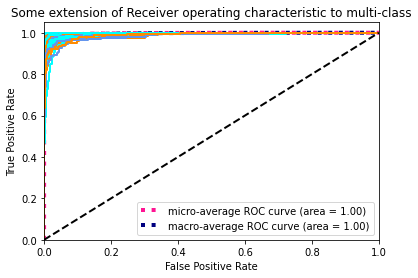

In [13]:
import torch
import torch.nn as nn
import os
import numpy as np
from torchvision.datasets import ImageFolder
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve, average_precision_score
 
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
 
# Data_root = r'd: \ tju \ gbdb \ set113 \ set113_images \ test1 '# test set path
test_path = "/content/drive/MyDrive/Assignment 6/vgg19.pth"     
num_class = 59 # Category Number
gpu = "cuda:0"  
 
 
# mean=[0.948078, 0.93855226, 0.9332005], var=[0.14589554, 0.17054074, 0.18254866]
def evaluation(model, test_loader):
        
    model.load_state_dict(torch.load(test_path))
    model.eval()
 
    score_list = [] # Store predictive score
    label_list = [] # Store a real label
    for i, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.cuda()
        labels = labels.cuda()
 
        outputs = model(inputs)
        # prob_tmp = torch.nn.Softmax(dim=1)(outputs) # (batchsize, nclass)
        score_tmp = outputs  # (batchsize, nclass)
 
        score_list.extend(score_tmp.detach().cpu().numpy())
        label_list.extend(labels.cpu().numpy())
 
    score_array = np.array(score_list)
         # Convert Label into oneHot form
    label_tensor = torch.tensor(label_list)
    label_tensor = label_tensor.reshape((label_tensor.shape[0], 1))
    label_onehot = torch.zeros(label_tensor.shape[0], num_class)
    label_onehot.scatter_(dim=1, index=label_tensor, value=1)
    label_onehot = np.array(label_onehot)
 
    print("score_array:", score_array.shape)  # (batchsize, classnum)
    print("label_onehot:", label_onehot.shape)  # torch.Size([batchsize, classnum])
 
         # Call the SklearN library, calculate the FPR and TPR corresponding to each category
    fpr_dict = dict()
    tpr_dict = dict()
    roc_auc_dict = dict()
    for i in range(num_class):
        fpr_dict[i], tpr_dict[i], _ = roc_curve(label_onehot[:, i], score_array[:, i])
        roc_auc_dict[i] = auc(fpr_dict[i], tpr_dict[i])
    # micro
    fpr_dict["micro"], tpr_dict["micro"], _ = roc_curve(label_onehot.ravel(), score_array.ravel())
    roc_auc_dict["micro"] = auc(fpr_dict["micro"], tpr_dict["micro"])
 
    # macro
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr_dict[i] for i in range(num_class)]))
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_class):
        mean_tpr += interp(all_fpr, fpr_dict[i], tpr_dict[i])
    # Finally average it and compute AUC
    mean_tpr /= num_class
    fpr_dict["macro"] = all_fpr
    tpr_dict["macro"] = mean_tpr
    roc_auc_dict["macro"] = auc(fpr_dict["macro"], tpr_dict["macro"])
 
         # Draw all categories average ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr_dict["micro"], tpr_dict["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc_dict["micro"]),
             color='deeppink', linestyle=':', linewidth=4)
 
    plt.plot(fpr_dict["macro"], tpr_dict["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc_dict["macro"]),
             color='navy', linestyle=':', linewidth=4)
 
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(num_class), colors):
        plt.plot(fpr_dict[i], tpr_dict[i], color=color, lw=lw)
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.savefig('set113_roc.jpg')
    plt.show()
 
 
if __name__ == '__main__':
    # Loading model
    model = models.vgg19_bn(pretrained=True)
    for param in model.features.parameters():
        param.require_grad = False

    # Newly created modules have require_grad=True by default
    num_features = model.classifier[6].in_features
    features = list(model.classifier.children())[:-1] # Remove last layer
    features.extend([nn.Linear(num_features, 59)]) # Add our layer with 4 outputs
    model.classifier = nn.Sequential(*features) # Replace the model classifier
    # seresnet = FineTuneSEResnet50(num_class=num_class)
    device = torch.device(gpu)
    model = model.to(device)
    evaluation(model, train_loader)

score_array: (2360, 59)
label_onehot: (2360, 59)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


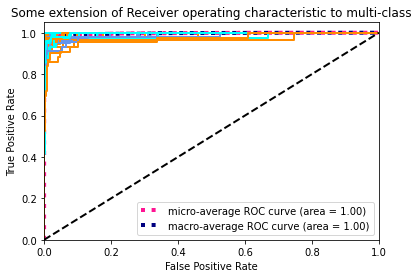

In [ ]:
test(model, valid_loader)

In [14]:
from sklearn.metrics import classification_report , confusion_matrix
import torch.nn.functional as F
def pred(model, test_loader):
    test_loss = 0
    correct = 0
    pred_list = []
    true = []
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(test_loader):

            data, label = data.to(device), label.to(device)

            output = model(data)
            y_pred = output.argmax(dim=1, keepdim=True).squeeze()

            pred_list.extend(y_pred.cpu().numpy())
            true.extend(label.cpu().numpy())
            # sum up batch loss

        pred_list = [a.squeeze().tolist() for a in pred_list]


    return true, pred_list

true, pred_list = pred(model, valid_loader)

print("Validation Classification Report:\n", classification_report(true, pred_list))

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97        39
           1       0.93      0.98      0.95        42
           2       0.95      0.93      0.94        44
           3       0.89      0.84      0.86        37
           4       0.88      0.97      0.93        38
           5       1.00      0.97      0.99        38
           6       0.94      0.98      0.96        46
           7       0.97      0.97      0.97        39
           8       0.97      0.97      0.97        39
           9       0.97      1.00      0.99        38
          10       1.00      0.96      0.98        49
          11       0.88      0.97      0.92        31
          12       0.95      0.95      0.95        38
          13       0.97      0.88      0.92        32
          14       0.97      0.97      0.97        39
          15       0.97      0.89      0.93        38
          16       0.97      0.97      0.97   

# Total Parameters

In [23]:
model = models.vgg19_bn(pretrained=True)
for param in model.features.parameters():
    param.require_grad = False

# Newly created modules have require_grad=True by default
num_features = model.classifier[6].in_features
features = list(model.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, 59)]) # Add our layer with 4 outputs
model.classifier = nn.Sequential(*features) # Replace the model classifier


model.load_state_dict(torch.load('/content/drive/MyDrive/Assignment 6/vgg19.pth'))
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')

total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

139,822,971 total parameters.
139,822,971 training parameters.


In [80]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [86]:
def get_examples(model , test_loader):

    with torch.no_grad():
        images, labels = iter(test_loader).next()
        for i in range(20):
            images, labels = iter(test_loader).next()
        images, labels = images.to(device), labels.to(device)
        model.to(device)
        output = model(images)
        predictions = output.argmax(dim=1, keepdim=True).squeeze()

        fig = plt.figure(figsize=(25, 6))
        for index in np.arange(15):
            ax = fig.add_subplot(3, 5, index+1, xticks=[], yticks=[])
            ax.imshow(np.transpose(images[index].cpu().numpy(), (1, 2, 0)), cmap='GnBu')
            ax.set_title("{} ({})".format(str(predictions[index].item()), str(labels[index].item())),
                         color=("green" if predictions[index]==labels[index] else "red"))
        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

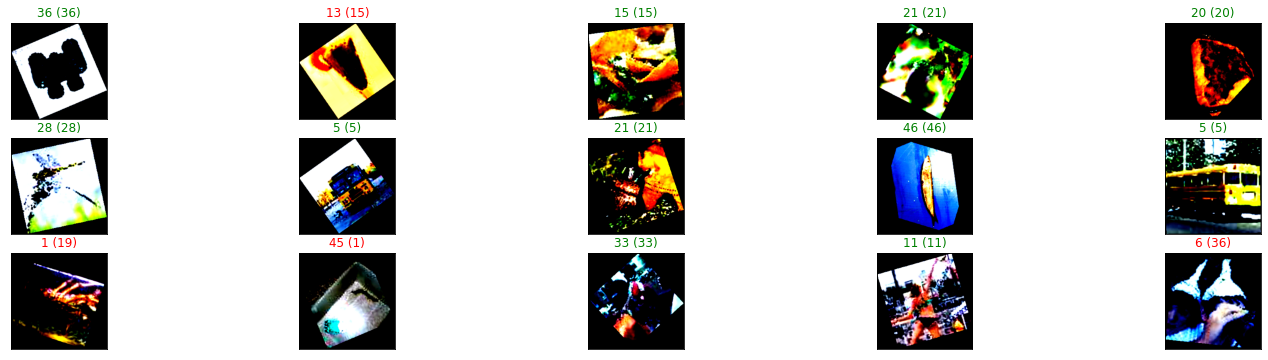

In [87]:
get_examples(model , train_loader)

In [78]:
import os
import torch
from torchvision import datasets, transforms
from random import randint,randrange
import pandas as pd

In [81]:
import os
import pandas as pd
import torch.nn.functional as F

imagenames=[]
preds=[]
probs=[]



from PIL import Image
import torchvision.transforms.functional as TF
# for data in testloader:
#     images, path = data
for name in os.listdir('/content/drive/MyDrive/Assignment 6/new_final_test'):
  image = Image.open('/content/drive/MyDrive/Assignment 6/new_final_test/'+name)
  data_transforms = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
  
  # x = TF.to_tensor(image)
  image = np.array(image)
  # print(len(image.shape))
  if len(np.array(image).shape) == 2:
    image = np.stack((image,)*3, axis=-1)
    
  image = Image.fromarray(np.uint8(image)).convert('RGB')
  x = data_transforms(image)
  x =  x.to(device)
  x.unsqueeze_(0)


  output = model(x)
  output = F.softmax(output, dim=1)
  pred = output.argmax(dim=1, keepdim=True).squeeze()


  probs.append(output.max().item())
  preds.append(pred.item())


  fname=name.split('.')[0]
  imagenames.append(fname)

   
new_list = list(zip(imagenames,preds,probs))
df = pd.DataFrame(new_list,columns = ['Name', 'Predicted_Class','Probability'])
df.to_csv('MSDS20030_06.csv', index=False)
print(df)

      Name  Predicted_Class  Probability
0      704                3     0.321888
1      364                2     0.341958
2     1735               36     0.416950
3      772               13     0.370688
4     1058               36     0.214037
...    ...              ...          ...
1765   551               36     0.203200
1766  1378               36     0.246392
1767  1547               36     0.246108
1768  1323               36     0.825930
1769  1104                3     0.356481

[1770 rows x 3 columns]
